# Fitting spectroscopic data with Bagpipes

Fitting spectroscopic data is an order of magnitude more complex than fitting photometric data. It's still not entirely clear to me how best to address all the problems that come up, and the answers naturally depend on the data you're dealing with. The following is what I currently believe to be best practice with Bagpipes when dealing with VIMOS spectroscopy such as the Lega-C spectrum in Example 2.

The results of this kind of analysis require very careful consideration to evaulate whether the modelling approach taken is returning reasonable answers and uncertainties. Please don't go getting ahead of yourself the second you see the model correctly lining up with your spectroscopic data!

## Setting up

Let's once again grab the functions from the second example which load up the observational data for us.

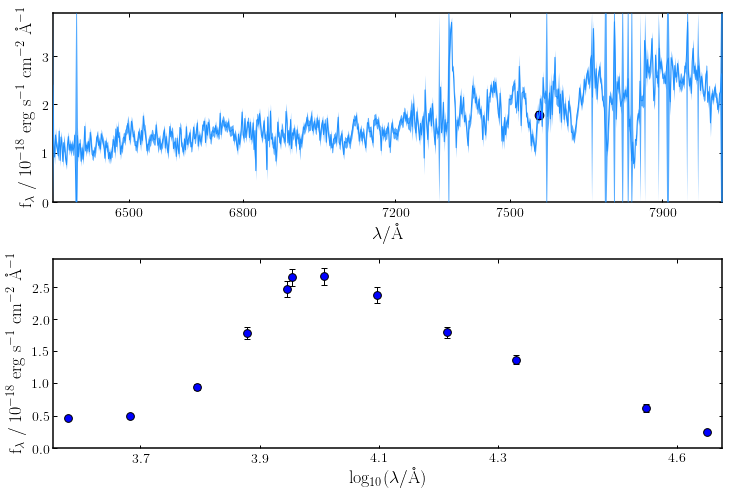

In [1]:
import numpy as np 
import bagpipes as pipes

from astropy.io import fits
from glob import glob
%matplotlib inline

uvista_filt_list = ["uvista/CFHT_u.txt",
                    "uvista/CFHT_g.txt",
                    "uvista/CFHT_r.txt",
                    "uvista/CFHT_i+i2.txt",
                    "uvista/CFHT_z.txt",
                    "uvista/subaru_z",
                    "uvista/VISTA_Y.txt",
                    "uvista/VISTA_J.txt",
                    "uvista/VISTA_H.txt",
                    "uvista/VISTA_Ks.txt",
                    "uvista/IRAC1",
                    "uvista/IRAC2"]


def load_uvista(ID):
    """ Load UltraVISTA photometry from catalogue. """

    # load up the relevant columns from the catalogue.
    hdulist = np.loadtxt("UltraVISTA_catalogue.cat",
                         usecols=(0,3,4,5,6,7,8,9,10,11,12,13,14,15,
                                  16,17,18,19,20,21,22,23,24,25,26))

    # Check the object is in the catalogue.
    if np.min(np.abs(hdulist[:,0] - int(ID))) != 0:
        sys.exit("Object not found in catalogue")

    tablerow = np.argmin(np.abs(hdulist[:,0] - int(ID)))

    # Extract the object we're interested in from the catalogue.
    phot_fluxes = hdulist[tablerow, 1:13]
    phot_fluxerrs = hdulist[tablerow, 13:25]

    phot = np.zeros(len(phot_fluxes)*2)
    phot.shape = (len(phot_fluxes), 2)
    
    # Convert to microjanskys
    phot[:,0] = phot_fluxes*10**29
    phot[:,1] = phot_fluxerrs*10**29

    # blow up the errors associated with any N/A points in the phot
    for i in range(len(phot)):
        if ((phot[i, 0] == 0. or phot[i, 1] <= 0) 
                or (phot[i, 1] > 0 and -phot[i, 0] >= 2*phot[i, 1])):
            phot[i,:] = [0., 9.9*10**99.]

    return phot


def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((nbins, spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_legac_spec(ID):
    """ Load legac spectroscopic data from file. """

    hdulist = fits.open(ID + ".fits")

    spectrum = np.zeros((hdulist[1].data["WAVE"].shape[1], 3))

    spectrum[:,0] = hdulist[1].data["WAVE"][0,:]
    spectrum[:,1] = hdulist[1].data["FLUX"][0,:]
    spectrum[:,2] = hdulist[1].data["ERR"][0,:]

    mask = hdulist[1].data["QUAL"][0,:]==1

    spectrum[:,1] *= 10**-19
    spectrum[:,2] *= 10**-19

    spectrum[mask, 2] = 10**10

    spectrum = spectrum[(spectrum[:,0] > 6300.) & (spectrum[:,0] < 8800.),:]

    return bin(spectrum, 4)


def load_both(ID):
    spectrum = load_legac_spec(ID)
    phot = load_uvista(ID)
    
    return spectrum, phot
    
    
galaxy = pipes.galaxy("96976", load_both, filt_list=uvista_filt_list)

fig = galaxy.plot()

## A fit instructions dictionary for spectroscopy

Let's start off with a model similar to the double-power-law model we fitted in Example 4 with nebular emission thrown in and Charlot & Fall (2001) dust instead of Calzetti.

In [2]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0.1, 2.)
dblplaw["metallicity_prior"] = "log_10"

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = (0., 2.0)
dust["n"] = (0.3, 2.5)
dust["n_prior"] = "Gaussian"
dust["n_prior_mu"] = 0.7
dust["n_prior_sigma"] = 0.3

fit_info = {}
fit_info["redshift"] = (0.75, 1.25)
fit_info["t_bc"] = 0.01
fit_info["redshift_prior"] = "Gaussian"
fit_info["redshift_prior_mu"] = 0.9
fit_info["redshift_prior_sigma"] = 0.05
fit_info["dblplaw"] = dblplaw 
fit_info["nebular"] = nebular
fit_info["dust"] = dust

Now we need to think about a few different issues. Firstly, we need to model the velocity dispersion in the spectrum. Bagpipes does this by convolving the spectroscopic output with a Gaussian kernel in velocity space. We can very the width of this kernel with:

In [3]:
fit_info["veldisp"] = (1., 1000.)   #km/s
fit_info["veldisp_prior"] = "log_10"

Now we need to think about relative flux calibration. There are a lot of effects to consider here, for example:
 - Aperture mismatch between spectroscopy and photometry
 - Innaccurate relative flux calibration as a function of wavelength in spectroscopic data
 - Underestimated uncertainties in spectroscopic data
 - Template mismatch between the models and data, which is a minor problem when fitting photometry, but a major one for fitting spectroscopy
 
The first technique I've found to be effective is to introduce a chebyshev polynomial perturbation to the spectroscopic data to deal with any calibration issues and to match the models. This is added to the model by adding a polynomial dictionary to the fit instructions dictionary:

In [4]:
poly = {}
poly["type"] = "bayesian"

poly["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
poly["0_prior"] = "Gaussian"
poly["0_prior_mu"] = 1.0
poly["0_prior_sigma"] = 0.25

poly["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
poly["1_prior"] = "Gaussian"
poly["1_prior_mu"] = 0.
poly["1_prior_sigma"] = 0.25

poly["2"] = (-0.5, 0.5)
poly["2_prior"] = "Gaussian"
poly["2_prior_mu"] = 0.
poly["2_prior_sigma"] = 0.25

fit_info["polynomial"] = poly

This introduces three new free parameters into the fit, which is going to slow things down. In order to try to mitigate this I've added another option which uses chi-squared minimisation to find the maximum likelihood polynomial for each spectral model that is compared to the data, instead of full Bayesian fitting of the polynomial.

This doesn't quite treat the uncertainties properly in a Bayesian way, but in most cases I think the difference should be minimial, this hasn't been extensively tested though. If you specify the "prior_width" key, a gaussian prior will be imposed on each point in the polynomial, centred on 1 with the width you specify (this also works for the Bayesian polynomial).

You can fit a maximum-likelihood polynomial with the following polynomial dictionary, however we'll continue with the Bayesian approach for now

In [5]:
mlpoly = {}
mlpoly["type"] = "max_like"
mlpoly["order"] = 2
mlpoly["prior_width"] = 0.25

Next up is dealing with potentially underestimated errors. The "noise" model component can be used to fit a multiplicative factor to all of the spectroscopic uncertainties as follows:

In [6]:
noise = {}
noise["sig_exp"] = (1., 10.)
noise["sig_exp_prior"] = "log_10"
fit_info["noise"] = noise

## Fitting the data

It's time to run the sampler. The higher dimensionality of this model means it's going to take a bit longer to sample the parameter space.

In [7]:
fit = pipes.fit(galaxy, fit_info, run="spectroscopy")

fit.fit(sampler="pmn")


Bagpipes: fitting object 96976 with PyMultiNest

  analysing data from pipes/posterior/spectroscopy/96976-.txt

Bagpipes: fitting complete in 4171.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dblplaw:alpha                 26.741     30.277     41.764
dblplaw:beta                   5.234     32.103    314.931
dblplaw:massformed            10.759     10.804     10.855
dblplaw:metallicity            0.414      0.483      0.610
dblplaw:tau                    4.768      4.903      5.284
dust:Av                        0.676      0.824      0.988
dust:n                         0.713      0.800      0.911
noise:sig_exp                  1.645      1.687      1.732
polynomial:0                   0.845      0.862      0.880
polynomial:1                   0.068      0.082      0.094
polynomial:2                   0.103      0.111      0.118
redshift        

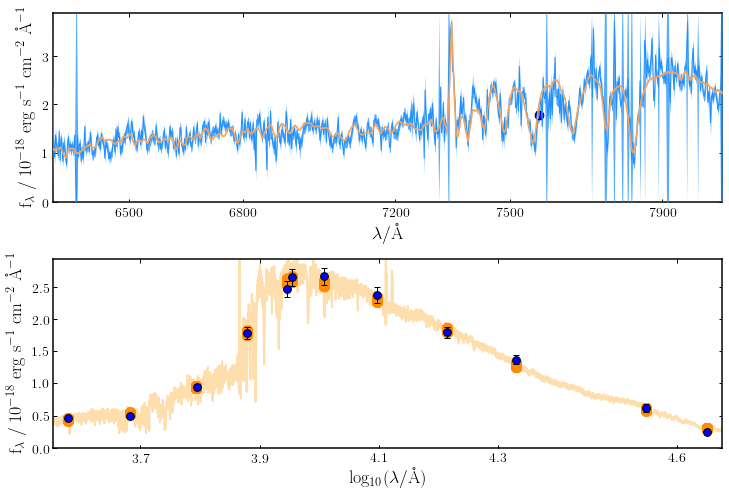

In [8]:
fig = fit.plot_fit(save=False)

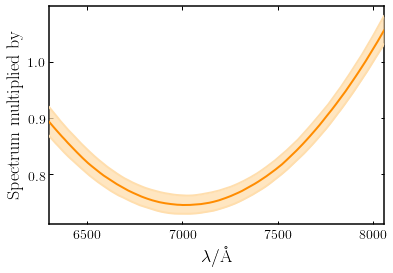

In [9]:
fig = fit.plot_poly(save=False)

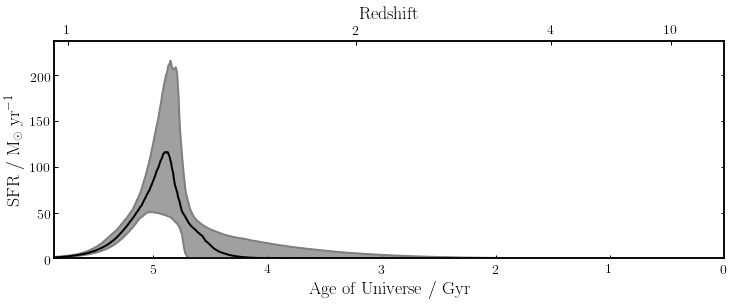

In [10]:
fig = fit.plot_sfh(save=False)

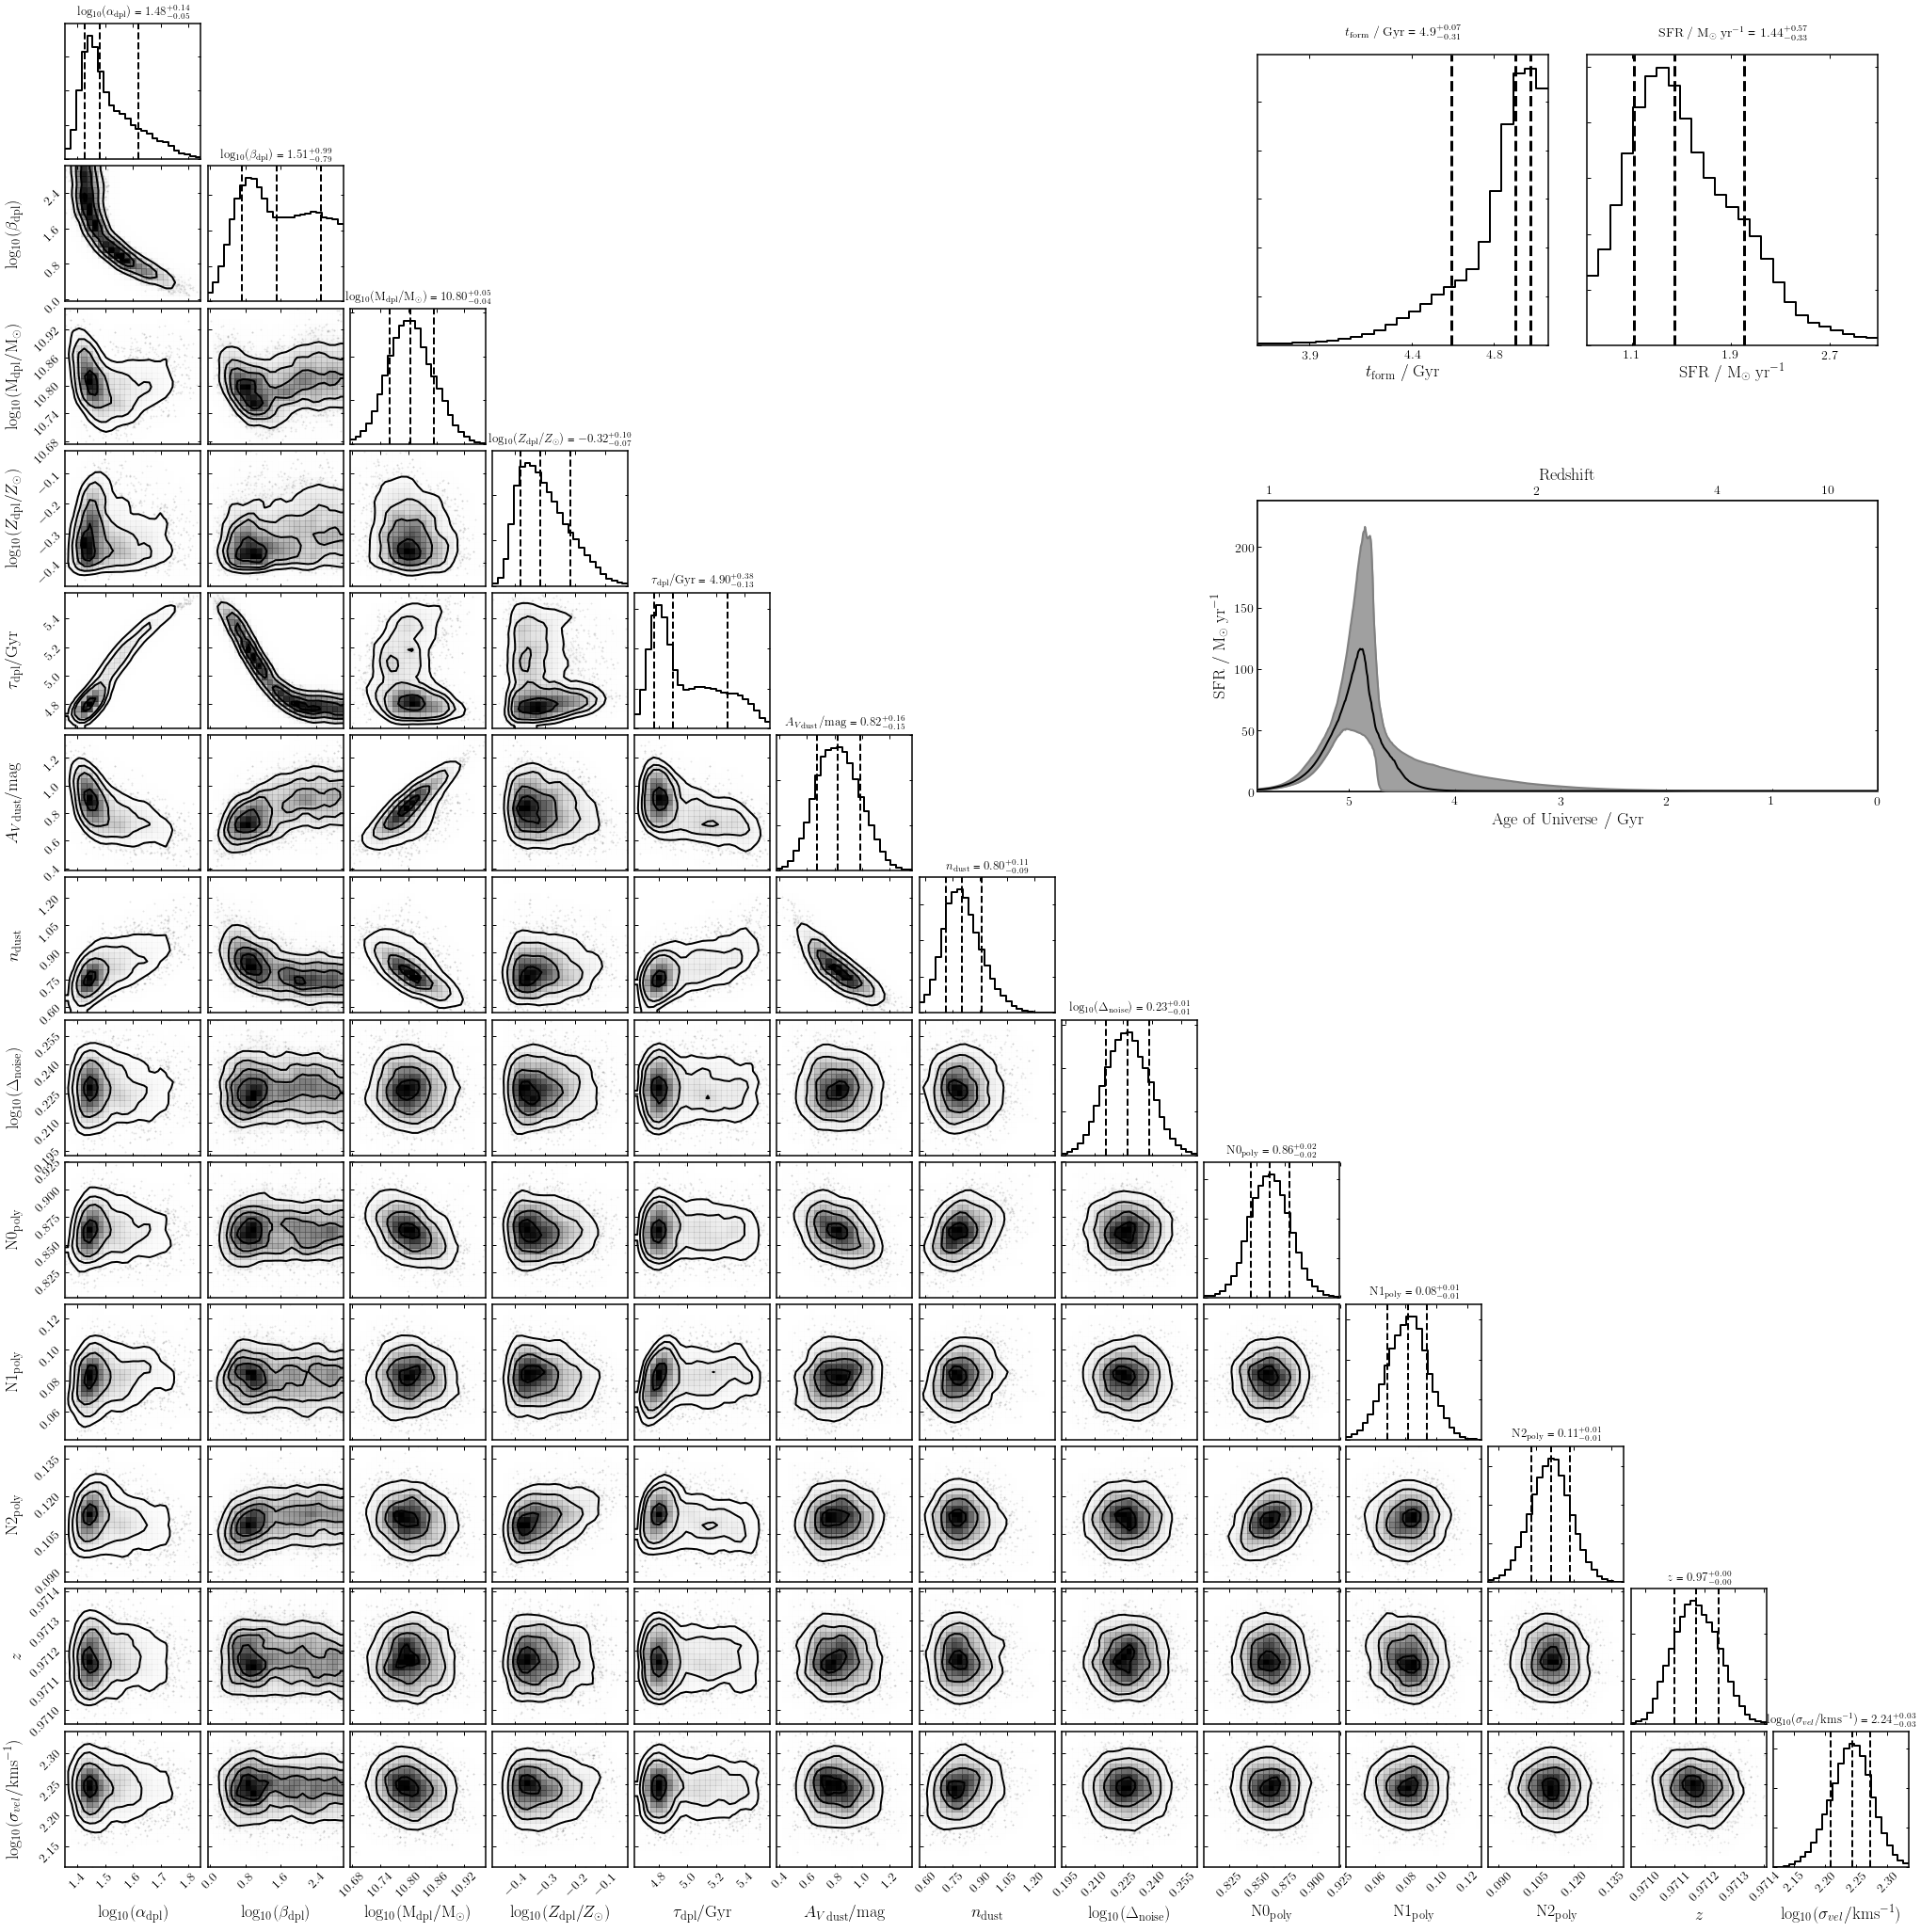

In [11]:
fig = fit.plot_corner(save=False)